# Joint optimization of PD and SD

This notebook explores the joint optimization of phase detection and stability detection.

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from paretoset import paretoset

In [ ]:
with open('/nethome/plavin3/sst/spec-utils/optimize/results/opt-poly-normal.out') as file:
    df = pd.read_csv(file, sep=' ', comment='#')

## Baseline

What was the score of the PD+SD used in past MF simulations?

In [28]:
orig = df[(df['threshold']    == 0.5)   &
          (df['phase_length'] == 10000) &
          (df['stable_min']   == 3)     &
          (df['window_start'] == 10)    &
          (df['summarize']    == 500)   &
          (df['proj_dist']    == 5)     & 
          (df['proj_delta']   == 2.0)   &
          (df['p_j']          == 4)]

print(f'Percent Swapped: {float(orig["pct"]):.3f}\nMean error:      {float(orig["acc"]):.3f}')

Percent Swapped: 0.856
Mean error:      6.415


## Basic Questions

1. What are the best values for each of the metrics?

For `pct`, higher is better. For `acc`, lower is better. (It should be `err`, not `acc`, really).

In [8]:
max_pct = max(df['pct'])
df[df['pct'] == max_pct]

,pct,acc,threshold,phase_length,stable_min,window_start,summarize,proj_dist,proj_delta,p_j
872,0.924754,6.47646,0.6,10000,4,20,1000,5,2.0,4


In [9]:
min_err = min(df['acc'])
df[df['acc'] == min_err]

,pct,acc,threshold,phase_length,stable_min,window_start,summarize,proj_dist,proj_delta,p_j
3762,0.520038,0.871201,0.6,50000,3,20,1000,10,0.5,10



1. Let's look at what values are the same:

    - `threshold`: Both take the maximum value of 0.6, indicating that a lower tolerace for determining similarity is alright
    - `window_start`: Both use the maximum value of 20, indicating that a larger window is good for accuracy but also find for time spent swapped.
    - `summarize`: Both use the maximum value of 1000


2. Now, where do they differ:

    - Remaining parameters for SD, `proj_dist`, `proj_delta`, `p_j`:
        - To get good accuracy, we need low tolerances for these. The high accuracy projects out further, requires tighter tolerances, and does more projection tests. However, this run is only swapped for about 50% of the time. **Question 1: if we just look at runs swapped over 80% of the time, how close can we get to an error of only 0.87?**
        
    - Remaining PD parameters, `phase_length`, `stable_min`:
        - Higher accuracy prefers a longer `phase_length`, but a smaller number of similar intervals required for stability (`stable_min`). 
        - **Question 2: How important are these? If we restrict ourselves to just the PD parameters used for high swap percentage, how close do we get to this accuracy goal?**

## Q1: If we just look at runs swapped over N% of the time, how close can we get to the minimum error of 0.871201?

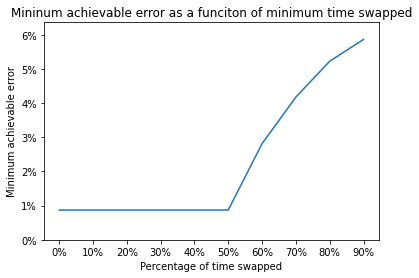

In [57]:
nx = 10

# Range is [min_pct, max_pct)
def pct_range(df, min_pct):
    return df[(df['pct'] >= min_pct)]

at_least = [(i/nx) for i in range(nx)]
min_err = []
for a in at_least:
    df_subset = pct_range(df, a)
    min_err.append(min(df_subset['acc']))

fig, ax = plt.subplots()
ax.plot(at_least, min_err)
ax.set_ylim(0, max(min_err)+0.5)
ax.set_xticks(at_least)
ax.set_xticklabels([f'{100*a:.0f}%' for a in at_least])
ax.set_yticks([int(i) for i in range(0,int(max(min_err))+2)])
ax.set_yticklabels([f'{int(i)}%' for i in range(0,int(max(min_err))+2)])
ax.set_xlabel('Percentage of time swapped')
ax.set_ylabel('Minimum achievable error')
ax.set_title('Mininum achievable error as a funciton of minimum time swapped')
plt.show()

What have we learned? From the parameters we have tried so far, the only way to get good accuracy is with a very low (~50%) amount of time spent swapped. We of course expected this relationship, but we need to see how far we can push the accuracy while keeping a relatively high swap percentage, say 80%.

## Question 2a: How important are `phase_length` and `stable_min`? If we restrict ourselves to just the PD parameters used for high swap percentage, how close do we get to this accuracy goal?

In [70]:
df_subset = df[(df['phase_length']==10_000) & (df['stable_min']==4)]
min_err_subset = min(df_subset['acc'])
res = float(df_subset[df_subset['acc'] == min_err_subset]['acc'])
print(f'Min error while using best phase_length and stable_min for high swap: {res:.3f}')

Min error while using best phase_length and stable_min for high swap: 1.511


## Question 2b: How important are `phase_length` and `stable_min`? If we restrict ourselves to just the *SD* parameters used for *low error*, how close do we get to this swap goal?

In [69]:
df_subset = df[(df['phase_length']==50_000) & (df['stable_min']==3)]
max_pct_subset = max(df_subset['pct'])
res = float(df_subset[df_subset['pct'] == max_pct_subset]['pct'])
print(f'Max percentage swapped while using best phase_length and stable_min for low error: {res:.3f}')

Max percentage swapped while using best phase_length and stable_min: 0.879


So we see that if we restrict ourselves to the best parameters for swap percentage, we can still achieve an accuracy of 1.5 (best was ~0.87), and if we restrict ourselves to the best parameters for low error, we can still achieve a swap percentage of 0.87 (best was ~0.92). 

This is somewhat heartening. Since we are more concerned with hitting a high accuracy, let's take the latter set of parameters for now.

## New Parameter Search

Now that we have learned a bit about the parameters, let's consider our next search space:

1. The parameters `threshold`, `window_start`, and `summarize` all maxed out their values. Let's add one larger value to all of those.

```
    threshold    = [0.6, 0.65]
    window_start = [20, 25]
    summarize    = [1000, 1500]
```

2. The parameters `phase_length` and `stable_min` were found to be relatively small, so we will restrict them for now.
```
    phase_length = [50_000]
    stable_min   = [3]
```

3. This leaves the three parameters we found to be very important for achieving high accuracy. Let's leave them alone for now.
```
    proj_dist  = [5, 10]
    proj_delta = [0.5, 1.0, 2.0]
    p_j        = [4, 6, 8, 10]
```

### Changes to scoring

Note that the scoring has changed slightly in this second set of data. Instead of a default score of (0,1), we now use a default of (0,0). A default score is used for traces with no RRs identified. The first number is the percent of time swapped, which of course is 0. The second number is the error, which I mistakenly set to be 1 before. The appropriate error for a trace with no RR is 0. This should not change the scoring very much.

In [130]:
with open('/nethome/plavin3/sst/spec-utils/optimize/results/opt-poly-normal-2.out') as file:
    df2 = pd.read_csv(file, sep=' ', comment='#')
with open('/nethome/plavin3/sst/spec-utils/optimize/results/opt-poly-normal-3.out') as file:
    df3 = pd.read_csv(file, sep=' ', comment='#')
with open('/nethome/plavin3/sst/spec-utils/optimize/results/opt-poly-normal-4.out') as file:
    df4 = pd.read_csv(file, sep=' ', comment='#')

In [73]:
# Highest swap percentage
df2[df2['pct'] == max(df2['pct'])]

,pct,acc,threshold,phase_length,stable_min,window_start,summarize,proj_dist,proj_delta,p_j
155,0.881869,5.96681,0.65,50000,3,20,1500,5,2.0,4


In [76]:
# Lowest Error
df2[df2['acc'] == min(df2['acc'])]

,pct,acc,threshold,phase_length,stable_min,window_start,summarize,proj_dist,proj_delta,p_j
6,0.417965,0.244749,0.60,50000,3,25,1500,10,0.5,10
7,0.417965,0.244749,0.65,50000,3,25,1500,10,0.5,10


Well, we managed to get even better error by running the models even less...

Let's look at some pareto style plots. 

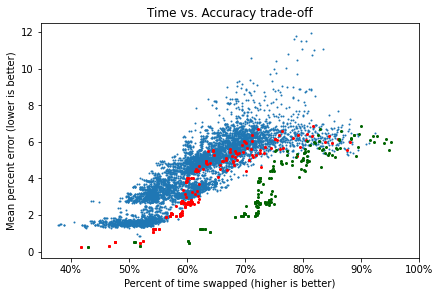

In [113]:
def pct_vs_err(ax, df, df2, df3, df4=None):
    xs = np.float64(df['pct'])
    ys = np.float64(df['acc'])
    ax.scatter(xs, ys, s=1, label='Experiment 1')
    
    xs = np.float64(df2['pct'])
    ys = np.float64(df2['acc'])
    ax.scatter(xs, ys, s=4, c='red', label='Experiment 2')
    
    xs = np.float64(df3['pct'])
    ys = np.float64(df3['acc'])
    ax.scatter(xs, ys, s=4, c='darkgreen', label='Experiment 3')
    
    if (df4 is not None):
        xs = np.float64(df4['pct'])
        ys = np.float64(df4['acc'])
        ax.scatter(xs, ys, s=4, c='lightgreen', label='Ex3 Pareto')
        
    nx = 10
    ax.set_xticks([i/nx for i in range(4, nx+1)])
    ax.set_xticklabels([f'{100*i/nx:.0f}%' for i in range(4, nx+1)])
    ax.set_xlabel('Percent of time swapped (higher is better)')
    
    ax.set_ylabel('Mean percent error (lower is better)')
    ax.set_title('Time vs. Accuracy trade-off')
    
fig, ax = plt.subplots(constrained_layout=True)
pct_vs_err(ax, df, df2, df3)
plt.show()

The next step is to modify the opitimizer to weight the `pct` value by the length of the various traces. Let's see how that changes the results of the second experiment. (See green values above)

Ok, so we've got more data. Should we re-run the analysis from before?

Let's calculate the pareo optimal values.

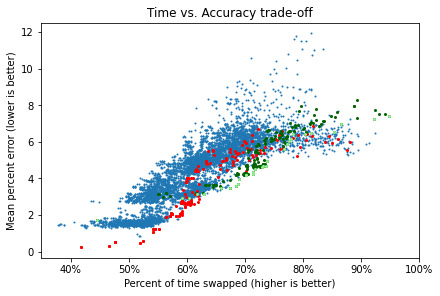

In [131]:
df_last = df4

mask = paretoset(df_last[['pct', 'acc']], sense=['max', 'min'])
fig, ax = plt.subplots(constrained_layout=True)
pct_vs_err(ax, df, df2, df_last, df_last[mask])
plt.show()

In [135]:
df_tmp = df_last[mask]

df_tmp[df_tmp['pct'] > .75]

,pct,acc,threshold,phase_length,stable_min,window_start,summarize,proj_dist,proj_delta,p_j
19,0.775742,6.05822,0.65,50000,3,25,1500,10,1.0,4
53,0.773365,5.88368,0.65,50000,3,20,1000,10,2.0,6
61,0.866270,6.98569,0.65,50000,3,25,1500,5,2.0,6
66,0.779697,6.16297,0.65,50000,3,25,1500,10,2.0,6
69,0.766687,5.61596,0.60,50000,3,20,1000,10,2.0,6
76,0.852816,6.53936,0.60,50000,3,25,1500,5,2.0,6
104,0.803910,6.43417,0.60,50000,3,20,1500,5,1.0,4
109,0.782291,6.40880,0.65,50000,3,25,1500,5,2.0,8
155,0.813563,6.47726,0.60,50000,3,25,1000,10,2.0,4
163,0.922403,7.21995,0.60,50000,3,20,1500,5,2.0,4


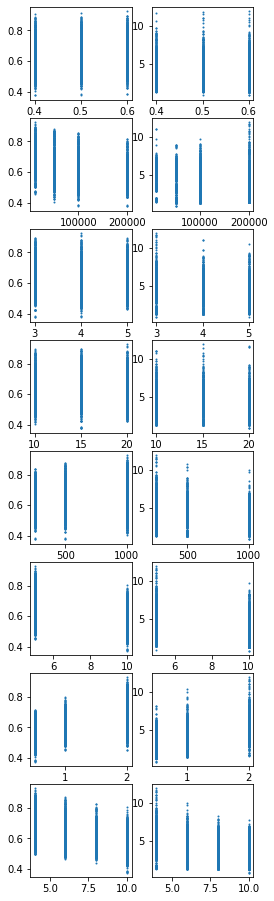

In [129]:
## Question: Do any parameter values always produce a result with percent error greater than X%? 

## Question: Do any parameter values always produce a result with time swapped less than Y%?

def plot_param(ax, df, x_param, y_param):
    ax.scatter(df[x_param], df[y_param], s=1)
    
fig, ax = plt.subplots(nrows=8, ncols=2)

y_params = ['pct', 'acc']
x_params = ['threshold', 'phase_length', 'stable_min', 'window_start', 'summarize', 'proj_dist', 'proj_delta', 'p_j']

for i, y_p in enumerate(y_params):
    for j, x_p in enumerate(x_params):
        plot_param(ax[j][i], df, x_p, y_p)
#plot_param(ax[0][0], df2, 'window_start', 'pct')
#plot_param(ax[0][0], df2, 'window_start', 'pct')

fig.set_size_inches((4, 16))

Ok, it's a bit hard to read that. 

Do we need to search more, or should we pick some parameters and re-run all the simulations? 

Do we need to evaluate on the full dataset? We could try that. 

# Version 2

In [199]:
with open('/nethome/plavin3/sst/spec-utils/optimize/results/opt-poly-subset-nanofix.out') as file:
    dfs = pd.read_csv(file, sep=' ', comment='#')

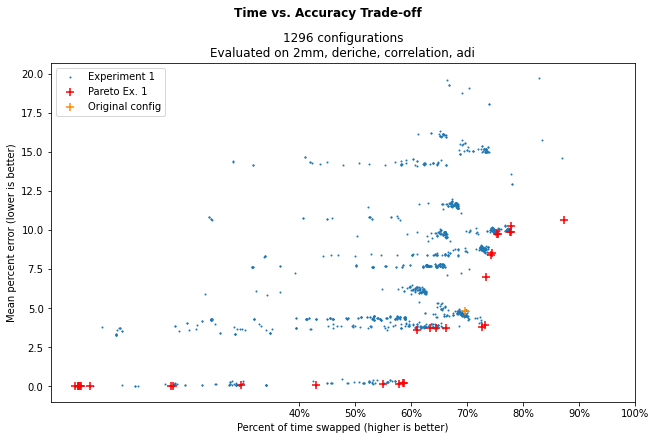

In [226]:
def pct_vs_err2(ax, df):
    xs = np.float64(df['pct'])
    ys = np.float64(df['acc'])
    ax.scatter(xs, ys, s=1, label='Experiment 1')
    
    mask = paretoset(df[['pct', 'acc']], sense=['max', 'min'])
    xs = np.float64(df[mask]['pct'])
    ys = np.float64(df[mask]['acc'])
    ax.scatter(xs, ys, s=60, label='Pareto Ex. 1', c='red', marker='+')
    
    # Original value
    # 0.697184 4.81026
    ax.scatter([0.697184], [4.81026], s=60, label='Original config', c='darkorange', marker='+')
        
    nx = 10
    ax.set_xticks([i/nx for i in range(4, nx+1)])
    ax.set_xticklabels([f'{100*i/nx:.0f}%' for i in range(4, nx+1)])
    ax.set_xlabel('Percent of time swapped (higher is better)')
    
    ax.set_ylabel('Mean percent error (lower is better)')
    ax.set_title('1296 configurations\nEvaluated on 2mm, deriche, correlation, adi')
    
    return mask
    
fig, ax = plt.subplots(constrained_layout=True)
fig.set_size_inches((6*1.5, 4*1.5))
pareto = pct_vs_err2(ax, dfs)
plt.legend()
plt.suptitle('Time vs. Accuracy Trade-off', weight='semibold')
plt.savefig('plots/time-vs-accuracy-trade-off.png')
plt.show()

In [198]:
dfs[pareto].sort_values('acc')

,pct,acc,threshold,phase_length,stable_min,window_start,summarize,proj_dist,proj_delta,p_j
159,0.000000,0.000000,0.65,10000,3,50,1000,10,0.5,10
440,0.005024,0.001582,0.50,100000,3,20,1500,10,0.5,10
807,0.005757,0.001757,0.50,50000,3,20,1500,10,0.5,10
677,0.006252,0.003547,0.50,10000,3,50,1500,10,0.5,10
616,0.008713,0.007729,0.50,10000,3,50,1500,10,0.5,8
147,0.010445,0.018371,0.50,10000,3,25,1500,10,0.5,10
645,0.025919,0.019689,0.60,50000,3,50,1000,10,0.5,8
365,0.170941,0.021045,0.60,100000,3,50,1500,10,0.5,10
153,0.175800,0.028602,0.50,100000,3,50,1500,10,0.5,8
369,0.296591,0.072307,0.50,10000,3,25,1500,10,1.0,10


In [225]:
dfs[pareto][dfs[pareto]['acc']<1].sort_values('pct')

,pct,acc,threshold,phase_length,stable_min,window_start,summarize,proj_dist,proj_delta,p_j
159,0.000000,0.000000,0.65,10000,3,50,1000,10,0.5,10
440,0.005024,0.001582,0.50,100000,3,20,1500,10,0.5,10
807,0.005757,0.001757,0.50,50000,3,20,1500,10,0.5,10
677,0.006252,0.003547,0.50,10000,3,50,1500,10,0.5,10
616,0.008713,0.007729,0.50,10000,3,50,1500,10,0.5,8
147,0.010445,0.018371,0.50,10000,3,25,1500,10,0.5,10
645,0.025919,0.019689,0.60,50000,3,50,1000,10,0.5,8
365,0.170941,0.021045,0.60,100000,3,50,1500,10,0.5,10
153,0.175800,0.028602,0.50,100000,3,50,1500,10,0.5,8
369,0.296591,0.072307,0.50,10000,3,25,1500,10,1.0,10


In [223]:
# Did any parameters only produce 'acc' values greater than 5? 
# Did any parameters only product 'pct' values lower than 0.5?

# Step 1: Get list of unique values for each parameter.

params_list = set(dfs.columns) - set(['acc', 'pct'])

for p in params_list:
    for u in set(dfs[p]):
    # check condition that subsetted df + acc cond has length > 0
        #print(f'[{p} = {u}] and [acc < 5]', len(dfs[(dfs[p]==u) & (dfs['acc'] < 5)]))
        #print(f'[{p} = {u}] and [pct > 0.5]', len(dfs[(dfs[p]==u) & (dfs['pct'] > 0.5)]))
        print(f'[{p} = {u}] and [acc < 5] and [pct > 0.5]', len(dfs[(dfs[p]==u) & (dfs['acc'] < 5) & (dfs['pct'] > 0.5)]))


[proj_dist = 10] and [acc < 5] and [pct > 0.5] 143
[proj_dist = 5] and [acc < 5] and [pct > 0.5] 194
[stable_min = 3] and [acc < 5] and [pct > 0.5] 337
[threshold = 0.6] and [acc < 5] and [pct > 0.5] 41
[threshold = 0.65] and [acc < 5] and [pct > 0.5] 48
[threshold = 0.5] and [acc < 5] and [pct > 0.5] 248
[p_j = 8] and [acc < 5] and [pct > 0.5] 78
[p_j = 10] and [acc < 5] and [pct > 0.5] 77
[p_j = 4] and [acc < 5] and [pct > 0.5] 102
[p_j = 6] and [acc < 5] and [pct > 0.5] 80
[window_start = 25] and [acc < 5] and [pct > 0.5] 127
[window_start = 50] and [acc < 5] and [pct > 0.5] 95
[window_start = 20] and [acc < 5] and [pct > 0.5] 115
[summarize = 1000] and [acc < 5] and [pct > 0.5] 165
[summarize = 1500] and [acc < 5] and [pct > 0.5] 172
[phase_length = 50000] and [acc < 5] and [pct > 0.5] 122
[phase_length = 10000] and [acc < 5] and [pct > 0.5] 94
[phase_length = 100000] and [acc < 5] and [pct > 0.5] 121
[proj_delta = 0.5] and [acc < 5] and [pct > 0.5] 110
[proj_delta = 1.0] and [acc 

In [227]:
TRACES

NameError: name 'TRACES' is not defined